In [ ]:
import torchphysics as tp
import numpy as np
import torch
from matplotlib import pyplot as plt
import pytorch_lightning as pl

In [3]:
# geometry information
d = 1 # diameter in mm
R = d/2/1e3 # radius in m
h_l = 0.005 # water height in m
h_c = 0.01 # capillary height
norm = R # characteristic capillary radius for normalization

# surface tension coefficient
sigma = 0.072

# densities (liquid/gas)
rho_l = 998.2
rho_g = 1.225

# contact angle
theta_value = 80.0
theta = theta_value * np.pi/180

# gravitational acceleration
g = 9.81

# Bond number
Bo = rho_l*g*R**2/sigma
print(f'Bond number: {Bo}')

# number of sample points
N_points_PDE = 10000
N_points_BC = 5000

Bond number: 0.0340011875


In [4]:
# Input and output spaces
X = tp.spaces.R2(variable_name='x')
Z = tp.spaces.R1('z')
LAMB = tp.spaces.R1('lamb')
Theta = tp.spaces.R1("theta")

Omega = tp.domains.Circle(space=X, center=[0, 0], radius=1)
interval_theta = tp.domains.Interval(Theta, 10 * np.pi/180.0, 170*np.pi/180.0)

In [5]:
# calculate normalized cross-sectional area and initial volume
A = np.pi*R**2/norm**2
V0 = A*h_l/norm

dA = A/N_points_PDE
dV = V0/N_points_PDE
print(A)
print(V0)

3.141592653589793
31.415926535897935


In [6]:
sampler_pde_condition = tp.samplers.RandomUniformSampler(Omega*interval_theta, n_points=N_points_PDE)
domain_boundary_condition  = Omega.boundary
sampler_boundary_condition = tp.samplers.RandomUniformSampler(domain_boundary_condition*interval_theta, 
                                                     n_points=N_points_BC)

In [7]:
def length_of_grad(grad_z):
    return torch.sqrt(1 + grad_z[:, :1]**2 + grad_z[:, 1:]**2)

def residual_pde_condition(z, x, lamb):
    grad_z = tp.utils.grad(z, x)
    len_grad = length_of_grad(grad_z)
    return tp.utils.div(grad_z/len_grad, x) - Bo*z - lamb

# calculate normal vectors prior to optimization to decrease computational effort
#normal_vectors = Omega.boundary.normal(sampler_boundary_condition.sample_points()).to('cuda')

def residual_boundary_condition(z, x, theta):
    grad_z = tp.utils.grad(z, x)
    len_grad = length_of_grad(grad_z)
    normal_vectors = Omega.boundary.normal(x)
    normal_grad = torch.sum(normal_vectors*grad_z, dim=1, keepdim=True)
    return normal_grad/len_grad - torch.cos(theta)

def residual_volume_condition(z):
    return torch.sum(z*dA, dim=0, keepdim=True) - V0

In [8]:
fcn_layer = tp.models.FCN(input_space=X*Theta, output_space=Z, hidden = (50, 50, 50, 50, 50, 50))

model = tp.models.Sequential(fcn_layer)

model_lamb = tp.models.FCN(input_space=Theta, output_space=LAMB, hidden = (20, 20, 20, 20))

combi_model = tp.models.Parallel(model, model_lamb)

In [9]:
pde_condition      = tp.conditions.PINNCondition(module      = combi_model, 
                                                 sampler     = sampler_pde_condition,
                                                 residual_fn = residual_pde_condition,
                                                 )

boundary_condition = tp.conditions.PINNCondition(module      = model, 
                                                 sampler     = sampler_boundary_condition,
                                                 residual_fn = residual_boundary_condition)

volume_condition   = tp.conditions.PINNCondition(module      = model, 
                                                 sampler     = sampler_pde_condition,
                                                 residual_fn = residual_volume_condition, 
                                                 )

In [11]:
training_conditions = [volume_condition, pde_condition, boundary_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

# Start the training
trainer = pl.Trainer(
    devices=1, # or None if CPU is used
    max_steps=80000, # number of training steps
    logger=False,
    benchmark=True,
    accelerator="cpu",
    # checkpoint_callback=False  # Uncomment this for more verbose
)
trainer.fit(solver) # start training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 14.3 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=80000` reached.


In [12]:
import time

pde_condition.sampler = pde_condition.sampler.make_static()
boundary_condition.sampler = boundary_condition.sampler.make_static()
volume_condition.sampler = volume_condition.sampler.make_static()

optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.1, 
                            optimizer_args={'max_iter': 5})
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)
# Start the training
trainer = pl.Trainer(
    devices=1, # or None if CPU is used
    max_steps=20000, # number of training steps
    logger=False,
    benchmark=True,
    accelerator="cpu",
    # checkpoint_callback=False  # Uncomment this for more verbose
)

start_time = time.time()
trainer.fit(solver) # start training
end_time = time.time()
print(f'Training time: {end_time - start_time} seconds')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fb3_f01/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/fb3_f01/YL-Equation/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 14.3 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/fb3_f01/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/home/fb3_f01/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=20000` reached.


Training time: 5396.203118562698 seconds


Elevation: 0.5759258


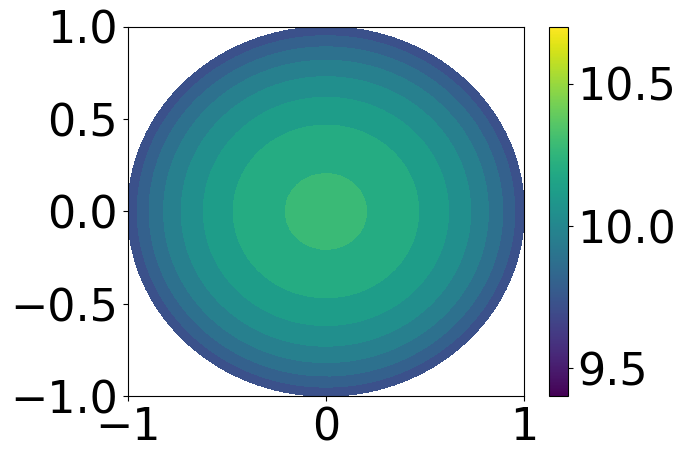

In [15]:
vmin = 9.4
vmax = 10.7
theta = 150.0

plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=3169, 
                                       data_for_other_variables={"theta": theta*np.pi/180.0})
sample_points = plot_sampler.sample_points()
output = model.forward(sample_points)

x_vis = sample_points.as_tensor[:,0].detach().numpy()
y_vis = sample_points.as_tensor[:,1].detach().numpy()
z_vis = output.as_tensor.detach().numpy().flatten()

elevation = (max(z_vis)-min(z_vis))

print("Elevation:", elevation)

from mpl_toolkits.mplot3d import axes3d
plt.rcParams['font.size'] = 32
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 'medium'

fig = plt.figure()
helper_color = plt.scatter([0, 0], [0, 0], c=[vmin, vmax],)
plt.tricontourf(x_vis, y_vis, z_vis, vmin=vmin, vmax=vmax)
plt.colorbar(helper_color)
plt.savefig(f"pinns_capillary_theta_{theta}_deg.png", dpi=300)
